In [1]:
import itertools
import matlab.engine
import plotly.express as px

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump

project_path = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'scripts'))
from multivariate.dataloader import ActivityPatternDataLoader
from multivariate.helper import compute_rdm, checkdir, scale_feature,lower_tri
from multivariate.modelrdms import ModelRDM
from multivariate.rsa_searchlight import RSASearchLight
from multivariate.rsa_estimator import PatternCorrelation,MultipleRDMRegression,NeuralDirectionCosineSimilarity
from multivariate.rsa_runner import RSARunner

from sklearn.manifold import MDS,TSNE
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
import scipy
import sklearn

In [3]:
#https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [2]:
with open(os.path.join(project_path,'scripts','pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nonlearners = pirate_defaults['participants']['nonlearnerids']
    nongeneralizers = pirate_defaults['participants']['nongeneralizerids']
    

preprocess = ["unsmoothedLSA","smoothed5mmLSA"]
n_sess = {
          "localizer":1,
          "noconcatall":1,
          "oddeven":2,
          "fourruns":4,
          }    


In [3]:
# maskdir = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis\data\fmri\masks\anat'
# laterality = ["left","right","bilateral"]
# laterality = ["bilateral"]
# with open(os.path.join(project_path,'scripts','anatomical_masks.json')) as f:    
#    anat_roi = list(json.load(f).keys())
# roi_dict = dict(zip(
#     ["frontal","ofc","hippocampus","parahippocampus","parietal"],
#     ["frontal","ofc","hippocampus","parahippocampus","parietal"]
#     ))
# roi_dict = dict(zip(anat_roi,anat_roi))
# ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','anatomic_ROIs')
# checkdir(ROIRSA_output_path)

maskdir = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis\data\fmri\masks\func\wbsearch_reg_respcompete_locwrtcetrefeature_combinexy'
laterality = ["bilateral"]
roi_dict = dict(zip(
    ['localxy - L Cuneus','localxy - L Mid Cingulate',
     'localxy - R Mid Frontal','localxy - R Sup Parietal', 
     'localxy - Sup SuppMotor', 
     'global - Calcarine',
     ],
    ['xydist_LeftCuneus','xydist_RightCingulateMid',
     'xydist_RightFrontalMid','xydist_RightParietalSup',
     'xydist_SuppMotor','xysign_Calcarine'
     ]
     ))
ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','funcroi_respcompete_locwrtcetrefeature')
checkdir(ROIRSA_output_path)

maskdir = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis\data\fmri\masks\func\wbsearch_reg_hierarchicalwrtcentre_combinexy'
laterality = ["bilateral"]
roi_dict = dict(zip(
    ['localxy - Cuneus','localxy - L Mid Frontal',
     'localxy - R Mid Frontal','localxy - Sup Parietal', 
     'global - Calcarine',
     ],
    ['xydist_Cuneus','xydist_LeftFrontalMid_sphere',
     'xydist_RightFrontalMid_sphere','xydist_ParietalSupL',
     'xysign_Calcarine'
     ]     
            ))
ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','funcroi_hierarchicalwrtcentre_combinexy')
checkdir(ROIRSA_output_path)

maskdir = r'D:\OneDrive - Nexus365\Project\pirate_fmri\Analysis\data\fmri\masks\func\wbsearch_reg_competefeaturecartesian_combinexy'
laterality = ["bilateral"]
roi_dict = dict(zip(
    ['cartesian - L Visual','cartesian - R Visual',
     'feature - L Mid Frontal','feature - L Insula', 
     'feature - L Precuneus','feature - L Temporal',
     'feature - Visual',
     ],
    ['gtloc_LeftVisual','gtloc_RightVisual',
     'feature2d_LeftFrontalmid','feature2d_LeftInsula',
     'feature2d_LeftPrecuneus','feature2d_LeftTemporal',
     'feature2d_Visual'
     ]     
            ))
ROIRSA_output_path = os.path.join(fmridata_dir,'ROIRSA','funcroi_competefeaturecartesian_combinexy')
checkdir(ROIRSA_output_path)

In [4]:
for p in preprocess[:1]:
    beta_dir = {
#        "fourruns":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')],
#        "noconcatall":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')],
#        "localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "fourruns":['stimuli_4r.nii'],
        "localizer":['stimuli_1r.nii'],
        "noconcatall":['stimuli_all.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              #"reliability_ths0":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              #"perm_rmask":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            vsmask_dir = ds + vdir
            if vselect == "no_selection":
                vsmask_fname = ['mask.nii']*len(ds)
            elif vselect == "perm_rmask":
                vsmask_fname = ['mask.nii']*len(ds) + ['permuted_reliability_mask.nii']
            elif vselect == "reliability_ths0":
                vsmask_fname = ['mask.nii']*len(ds) + ['reliability_mask.nii']
            taskname = "navigation" if ds_name != "localizer" else ds_name
            for (roi,roi_fn), lat in list(itertools.product(roi_dict.items(), laterality))[:2]:
                print(f"{p} - {ds_name} - {vselect} - {roi} = {lat}")
                anatmasks = [os.path.join(maskdir,f'{roi_fn}_{lat}.nii')]
                anatmasks = [os.path.join(maskdir,f'{roi_fn}.nii')]
                RSA = RSARunner(participants=subid_list,
                                fmribeh_dir=fmribeh_dir,
                                beta_dir=ds, beta_fname=beta_fname[ds_name],
                                vsmask_dir=vsmask_dir, vsmask_fname=vsmask_fname,
                                pmask_dir=ds, pmask_fname=beta_fname[ds_name],
                                anatmasks=anatmasks,
                                nsession=n_sess[ds_name],
                                taskname=taskname)

unsmoothedLSA - oddeven - no_selection - cartesian - L Visual = bilateral
unsmoothedLSA - oddeven - no_selection - cartesian - R Visual = bilateral


In [12]:
activitypattern,neuralrdm,ev = RSA.get_neuralRDM(subid=subid_list[0])
modelrdm = RSA.get_modelRDM(subid=subid_list[0])

In [14]:
unique_x, unique_y = list(np.unique(modelrdm.stimdf["stim_x"])), list(np.unique(modelrdm.stimdf["stim_y"]))

fit_filter = np.array(modelrdm.stimdf["stim_session"] == 0)
eval_filter = ~fit_filter

neuraldata = {
    "fit":activitypattern[fit_filter,:],
    "eval":activitypattern[eval_filter,:]
}
stimdf = {"fit": modelrdm.stimdf[fit_filter],
          "eval": modelrdm.stimdf[eval_filter]}

featurex_filters,featurey_filters = {},{}
for k,v in stimdf.items():
    featurex_filters[k] = [np.array(v["stim_x"]==x) for x in unique_x]
    featurey_filters[k] = [np.array(v["stim_y"]==y) for y in unique_y]

AP_featurex = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurex_filters["fit"]])
AP_featurey = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurey_filters["fit"]])

feature_matrix = np.array(stimdf["eval"][["stim_x","stim_y"]])
n_sample = stimdf["eval"].shape[0]
sample_id = 0
AP_compo = np.array(
    [AP_featurex[unique_x.index(feature_matrix[sample_id,0]),:] + AP_featurey[unique_x.index(feature_matrix[sample_id,1]),:] for sample_id in range(n_sample)]
    )

res = scipy.stats.spearmanr(lower_tri(compute_rdm(neuraldata["eval"],"correlation"))[0],
                      lower_tri(compute_rdm(AP_compo,"correlation"))[0],
                      )
res.statistic
#AP_compo
#activitypattern

0.06157890643229368

SignificanceResult(statistic=0.22727114623956002, pvalue=0.1332509694201683)
SignificanceResult(statistic=-0.0044186534398728905, pvalue=0.9770183318209826)


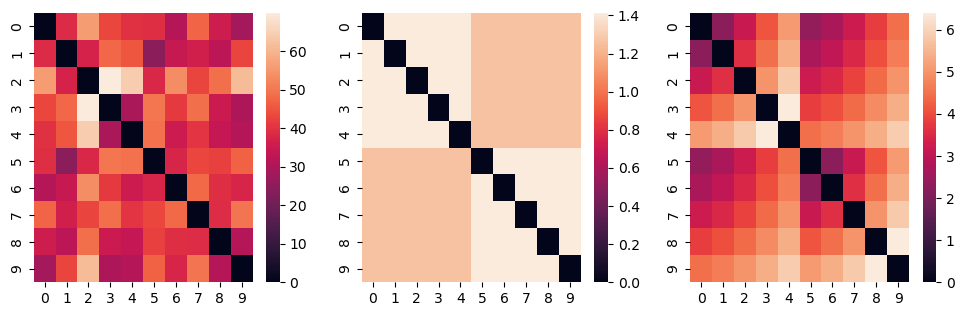

In [81]:
AP_feature = np.concatenate([AP_featurex,AP_featurey],axis=0)
neural_feature_rdm = compute_rdm(AP_feature,"euclidean")
discretefeature_matrix = np.vstack([np.concatenate(arrs) for arrs in list(itertools.product(np.eye(5),np.eye(5)))])
continuousfeature_matrix = np.vstack([np.concatenate(arrs) for arrs in list(itertools.product(np.diag([1,2,3,4,5]),np.diag([1,2,3,4,5])))])


discretefeaturexy = np.concatenate(
    [np.array([np.mean(discretefeature_matrix[f_filter,:],axis=0) for f_filter in featurex_filters["fit"]]),
     np.array([np.mean(discretefeature_matrix[f_filter,:],axis=0) for f_filter in featurey_filters["fit"]])
],axis=0
)
continuousfeaturexy = np.concatenate(
    [np.array([np.mean(continuousfeature_matrix[f_filter,:],axis=0) for f_filter in featurex_filters["fit"]]),
     np.array([np.mean(continuousfeature_matrix[f_filter,:],axis=0) for f_filter in featurey_filters["fit"]])
],axis=0
)

discretefeature_rdm = compute_rdm(discretefeaturexy,"euclidean")
continuousfeature_rdm = compute_rdm(continuousfeaturexy,"euclidean")

fig,axes = plt.subplots(1,3,figsize=(12,3.5))
sns.heatmap(neural_feature_rdm,ax=axes[0])
sns.heatmap(discretefeature_rdm,ax=axes[1])
sns.heatmap(continuousfeature_rdm,ax=axes[2])


print(scipy.stats.spearmanr(lower_tri(neural_feature_rdm)[0],lower_tri(discretefeature_rdm)[0]))
print(scipy.stats.spearmanr(lower_tri(neural_feature_rdm)[0],lower_tri(continuousfeature_rdm)[0]))

<Axes: >

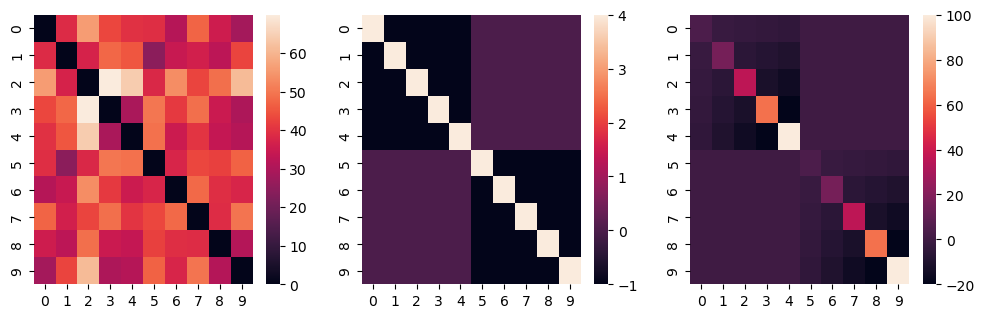

In [78]:
AP_feature = np.concatenate([AP_featurex,AP_featurey],axis=0)
neural_feature_rdm = compute_rdm(AP_feature,"euclidean")
discretefeature_matrix = np.vstack([np.concatenate(arrs) for arrs in list(itertools.product(np.eye(5),np.eye(5)))])
continuousfeature_matrix = np.vstack([np.concatenate(arrs) for arrs in list(itertools.product(np.diag([1,2,3,4,5]),np.diag([1,2,3,4,5])))])
sdfm,scfm = scale_feature(discretefeature_matrix,1,False), scale_feature(continuousfeature_matrix,1,False)
fig,axes = plt.subplots(1,3,figsize=(12,3.5))
sns.heatmap(neural_feature_rdm,ax=axes[0])
sns.heatmap(sdfm.T@sdfm,ax=axes[1])
sns.heatmap(scfm.T@scfm,ax=axes[2])

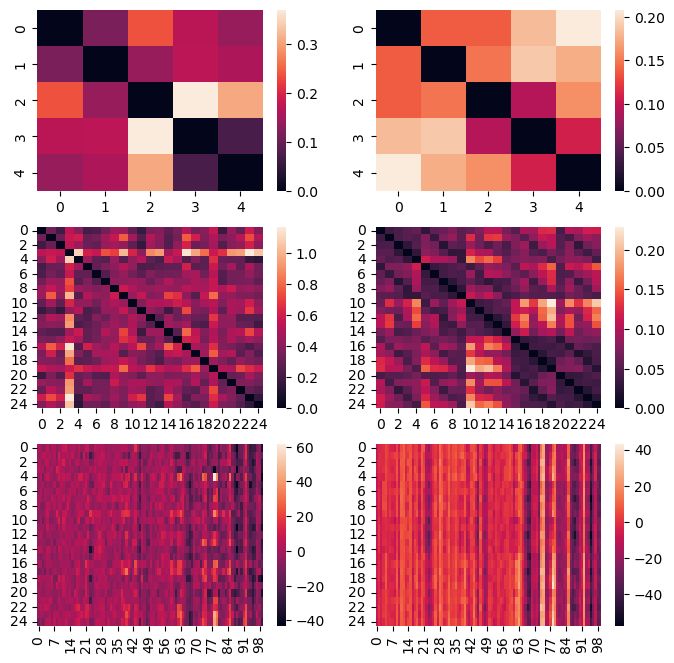

In [19]:
neuraldata["eval"]
AP_compo

fig,axes = plt.subplots(3,2,figsize=(8,8))
sns.heatmap(compute_rdm(AP_featurex,"correlation"),ax=axes[0,0])
sns.heatmap(compute_rdm(AP_featurey,"correlation"),ax=axes[0,1])
sns.heatmap(compute_rdm(neuraldata["eval"],"correlation"),ax=axes[1,0])
sns.heatmap(compute_rdm(AP_compo,"correlation"),ax=axes[1,1])
sns.heatmap(neuraldata["eval"],ax=axes[2,0])
sns.heatmap(AP_compo,ax=axes[2,1])

res = []
for y,yh in zip(neuraldata["eval"],AP_compo):
    linreg_res = scipy.stats.linregress(yh,y)
    res.append(linreg_res.slope)

In [54]:
print(np.mean(res))
print(scipy.stats.linregress(neuraldata["eval"].flatten(),AP_compo.flatten()).slope)
import statsmodels.api as sm
import statsmodels.formula.api as smf
df1 = pd.melt(pd.DataFrame(neuraldata["eval"],columns=list(range(neuraldata["eval"].shape[1]))).assign(stim_id=list(range(neuraldata["eval"].shape[0]))),
        id_vars="stim_id",value_vars=list(range(neuraldata["eval"].shape[1])),
        value_name="true_activity",var_name="voxel")#.assign(split="truedata")
df2 = pd.melt(pd.DataFrame(AP_compo,columns=list(range(neuraldata["eval"].shape[1]))).assign(stim_id=list(range(neuraldata["eval"].shape[0]))),
        id_vars="stim_id",value_vars=list(range(neuraldata["eval"].shape[1])),
        value_name="pred_activity",var_name="voxel")#.assign(split="preddata")
#pd.concat([df1,df2],axis=0).reset_index()
neuralcompo_df = deepcopy(df1)
neuralcompo_df["pred_activity"] = df2["pred_activity"]
md = smf.mixedlm("true_activity ~ pred_activity", neuralcompo_df, groups=neuralcompo_df["stim_id"])
mdres = md.fit()
#mdres.summary()
print(mdres.params["pred_activity"])

df1 = pd.melt(pd.DataFrame(neuraldata["fit"],columns=list(range(neuraldata["eval"].shape[1]))).assign(stim_id=list(range(neuraldata["eval"].shape[0]))),
        id_vars="stim_id",value_vars=list(range(neuraldata["eval"].shape[1])),
        value_name="true_activity",var_name="voxel")#.assign(split="truedata")
df2 = pd.melt(pd.DataFrame(neuraldata["eval"],columns=list(range(neuraldata["eval"].shape[1]))).assign(stim_id=list(range(neuraldata["eval"].shape[0]))),
        id_vars="stim_id",value_vars=list(range(neuraldata["eval"].shape[1])),
        value_name="pred_activity",var_name="voxel")#.assign(split="preddata")
#pd.concat([df1,df2],axis=0).reset_index()
neuralcompo_df = deepcopy(df1)
neuralcompo_df["pred_activity"] = df2["pred_activity"]
md = smf.mixedlm("true_activity ~ pred_activity", neuralcompo_df, groups=neuralcompo_df["stim_id"])
mdres = md.fit()
#mdres.summary()
print(mdres.params["pred_activity"])

0.4864356189547279
0.8711689680579199
0.48309945529674575
0.44305869423465843


In [62]:
scipy.stats.spearmanr(
    neuraldata["fit"].flatten(),
    neuraldata["eval"].flatten()
)

SignificanceResult(statistic=0.4254958614873379, pvalue=1.7142199638045223e-110)

In [61]:
scipy.stats.spearmanr(
    lower_tri(compute_rdm(neuraldata["fit"],"correlation"))[0],
    lower_tri(compute_rdm(neuraldata["eval"],"correlation"))[0]
)

SignificanceResult(statistic=-0.016158846209402326, pvalue=0.7804526363328085)

In [ ]:
import numpy
class NeuralCompositionality:
    def __init__(self,activitypattern:numpy.ndarray,stim_dict:dict,seed:int=None) -> None:
        self.X = activitypattern
        self.stimid = stim_dict["stimid"]
        self.stimsession = stim_dict["stimsession"]
        self.stimloc = stim_dict["stimloc"]
        self.stimfeature = stim_dict["stimfeature"]
        self.stimgroup = stim_dict["stimgroup"]
        self.seed = seed

    def fit(self):
        stim_x, stim_y = self.stimloc[:,0], self.stimloc[:,1]
        unique_x, unique_y = list(np.unique(stim_x)), list(np.unique(stim_y))
        result = []
        for fit_sess in [0,1]:
            fit_filter = np.array(self.stimsession == fit_sess)
            eval_filter = ~fit_filter

            neuraldata = {
                "fit":activitypattern[fit_filter,:],
                "eval":activitypattern[eval_filter,:]
            }
            stim_xfit,stim_yfit = stim_x[fit_filter], stim_y[fit_filter]
            # use the fitting data to generate representation patterns for different feature APfeature_x and APfeature_y
            featurex_filters = [np.array(stim_xfit==x) for x in unique_x]
            featurey_filters = [np.array(stim_yfit==y) for y in unique_y]
            APfeature_x = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurex_filters])
            APfeature_y = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurey_filters])

            # in the eval set compute how well the representation pattern composed from different APfeature matrices correlate with the original data
            feature_matrix = self.stimloc[eval_filter,:]
            n_sample = feature_matrix.shape[0]
            AP_compo = np.array(
                [APfeature_x[unique_x.index(feature_matrix[sample_id,0]),:] + APfeature_y[unique_x.index(feature_matrix[sample_id,1]),:] for sample_id in range(n_sample)]
                )
            rdm_oriAP = lower_tri(compute_rdm(neuraldata["eval"],"correlation"))[0]
            rdm_compoAP = lower_tri(compute_rdm(AP_compo,"correlation"))[0]
            result.append(scipy.stats.spearmanr(rdm_oriAP,rdm_compoAP).statistic)
        self.result = numpy.array(result)
        return self

In [6]:
spearmanr_res = []
fit_sess_list = []
for subid in subid_list:
    activitypattern,neuralrdm,ev = RSA.get_neuralRDM(subid=subid)
    modelrdm = RSA.get_modelRDM(subid=subid)

    unique_x, unique_y = list(np.unique(modelrdm.stimdf["stim_x"])), list(np.unique(modelrdm.stimdf["stim_y"]))

    for fit_sess in [0,1]:
        print(f"{subid} - {fit_sess}", end="\r")
        fit_filter = np.array(modelrdm.stimdf["stim_session"] == fit_sess)
        eval_filter = ~fit_filter

        neuraldata = {
            "fit":activitypattern[fit_filter,:],
            "eval":activitypattern[eval_filter,:]
        }
        stimdf = {"fit": modelrdm.stimdf[fit_filter],
                "eval": modelrdm.stimdf[eval_filter]}

        featurex_filters,featurey_filters = {},{}
        featurex_filters["fit"] = [np.array(stimdf["fit"]["stim_x"]==x) for x in unique_x]
        featurey_filters["fit"] = [np.array(stimdf["fit"]["stim_y"]==y) for y in unique_y]

        AP_featurex = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurex_filters["fit"]])
        AP_featurey = np.array([np.mean(neuraldata["fit"][f_filter,:],axis=0) for f_filter in featurey_filters["fit"]])

        feature_matrix = np.array(stimdf["eval"][["stim_x","stim_y"]])
        n_sample = stimdf["eval"].shape[0]
        AP_compo = np.array(
            [AP_featurex[unique_x.index(feature_matrix[sample_id,0]),:] + AP_featurey[unique_x.index(feature_matrix[sample_id,1]),:] for sample_id in range(n_sample)]
            )
        rdm_oriAP = lower_tri(compute_rdm(neuraldata["eval"],"correlation"))[0]
        rdm_compoAP = lower_tri(compute_rdm(AP_compo,"correlation"))[0]
        spearmanr_res.append(scipy.stats.spearmanr(rdm_oriAP,rdm_compoAP).statistic)
        fit_sess_list.append(fit_sess)

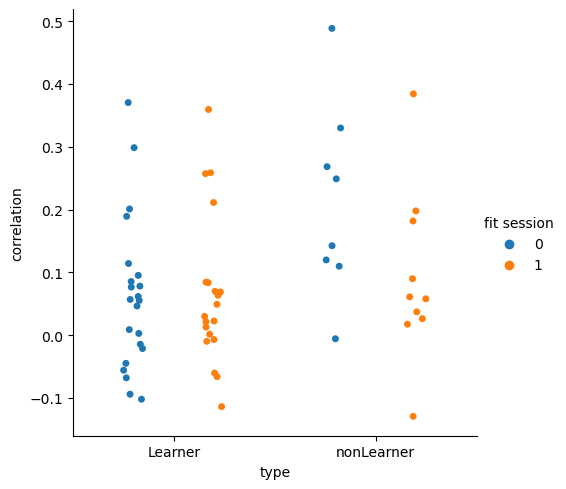

In [11]:
res_df = pd.DataFrame({"subid":subid_list+subid_list,"fit session":fit_sess_list,"correlation":spearmanr_res})
res_df
sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                'g':{1:'nonGeneralizer',0:'Generalizer'}}
res_df['type'] = res_df['subid'].apply(
                lambda x: f"{sub_type_dict['l'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
sns.catplot(res_df,x="type",y="correlation",hue="fit session",kind="strip",dodge=True)

## d

In [ ]:
corr_rdm_names = [
                    "feature2d",
                    "gtlocEuclidean",
                    "global_xysign",
                    "locwrtcentre_localxy",
                    "locwrtlrbu_localxy",
                    "respglobal_xysign",
                    "resplocwrtcentre_localxy"
                 ]
modelrdm_cols_oldname = corr_rdm_names
modelrdm_cols_newname = modelrdm_cols_oldname
modelrdm_cols = dict(zip(modelrdm_cols_oldname,modelrdm_cols_newname))

for p in preprocess[:1]:
    beta_dir = {
#        "fourruns":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')],
#        "noconcatall":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')],
#        "localizer":[os.path.join(fmridata_dir,p,'LSA_stimuli_localizer')],
        "oddeven":[os.path.join(fmridata_dir,p,'LSA_stimuli_navigation')]*2,

        }
    beta_fname = {
        "fourruns":['stimuli_4r.nii'],
        "localizer":['stimuli_1r.nii'],
        "noconcatall":['stimuli_all.nii'],
        "oddeven":['stimuli_odd.nii',
                   'stimuli_even.nii'],
        
        }
    vs_dir = {
              "no_selection":[],
              #"reliability_ths0":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              #"perm_rmask":[os.path.join(fmridata_dir,p,'reliability_noconcat')],
              }
    for ds_name,ds in beta_dir.items():
        for vselect,vdir in vs_dir.items():
            df = pd.read_csv(os.path.join(ROIRSA_output_path,f'roirdm_nocentering_{p}_{ds_name}_{vselect}.csv'))
            sub_type_dict = {'l':{1:'nonLearner',0:'Learner'},
                            'g':{1:'nonGeneralizer',0:'Generalizer'}}
            df['type'] = df['subid'].apply(
                lambda x: f"{sub_type_dict['g'][int(x in nongeneralizers)]}" #{sub_type_dict['l'][int(x in nonlearners)]} - 
            )
            df['run_comb'] = 1*(df['runA'] == df['runB'])
            df['run_comb'] = df['run_comb'].map({0:"between run",1:"within run"})
            df['group_comb'] = 1*(df['groupA'] == df['groupB'])
            df['group_comb'] = df['group_comb'].map({0:"between group",1:"within group"})
            #df = df[((df['groupA']==0)&(df['groupB']==0))]
            #df = df[(df['run_comb']=="between run")]
            for m,mn in modelrdm_cols.items():
                if m in df.columns :
                    fig_suptitle = f'{p} - {ds_name} - {vselect} - {mn}'
                    print(fig_suptitle)
                    plt.ioff()
                    prows, pcols = np.unique(df['run_comb']).size, len(roi_dict)
                    fig,axes = plt.subplots(nrows=prows,ncols=pcols,figsize=(60, 20))
                    j = 0
                    for _,(g_name,g_df) in list(enumerate(df.groupby(['laterality','run_comb','roi']))):
                        if ('bilateral' in g_name) & (g_name[2] in roi_dict):                            
                            if 'resplocwrtcentre' not in m:
                                subdf = g_df.groupby([m,'type','subid'])['neural'].mean().reset_index()
                                sns.lineplot(data=g_df,x=m,y='neural',ax=axes.flatten()[j],
                                            hue='type',palette=['blue','green'],#,'orange','red'],
                                            err_style="bars",errorbar=("se", 1),
                                            markers=True,alpha=1,linewidth=2.5)
                                #sns.lineplot(data=subdf,x=m,y='neural',ax=axes.flatten()[j],estimator=None,units="subid",
                                #            hue='type',palette=['blue','green'],#,'orange','red'],
                                #            alpha=0.2,linewidth = 1)
                            else:
                                type_colours = dict(zip(np.unique(g_df['type']),['blue','green']))
                                groups = g_df.groupby(["type","subid"])[[m,"neural"]]
                                mean, std = groups.transform("mean"), groups.transform("std")
                                normalized = (g_df[mean.columns] - mean) / std
                                g_df[mean.columns] = normalized
                                sns.regplot(data=g_df[g_df['type']=="Generalizer"],
                                            x=m,y='neural',ax=axes.flatten()[j],
                                            #scatter_kws={'alpha':0.01},
                                            units="subid",
                                            scatter=False,
                                            #ci=None,
                                            line_kws={'alpha':0.1},
                                            color=type_colours["Generalizer"])
                                sns.regplot(data=g_df[g_df['type']=="nonGeneralizer"],
                                            x=m,y='neural',ax=axes.flatten()[j],
                                            #scatter_kws={'alpha':0.01},
                                            units="subid",
                                            scatter=False,
                                            #ci=None,
                                            line_kws={'alpha':0.1},
                                            color=type_colours["nonGeneralizer"])
                            
                            axes.flatten()[j].set_title(g_name[2])
                            axes.flatten()[j].set(adjustable="datalim")
                            j += 1
                    
                    lines_labels = axes.flatten()[0].get_legend_handles_labels()
                    [ax.get_legend().remove() for ax in fig.axes if ax.get_legend() is not None]
                    lines, labels = [sum(lol, []) for lol in zip(lines_labels)]
                    #select unique legends
                    lgd_idx = [np.where(np.array(labels)==x)[0][0] for x in np.unique(labels)]
                    lines, labels = np.array(lines)[lgd_idx],np.array(labels)[lgd_idx]
                    lgd = fig.legend(lines, labels,loc = 'lower center',bbox_to_anchor=(0.5,1), ncol=6)
                    
                    grid = plt.GridSpec(prows, pcols)
                    create_subtitle(fig, grid[0, ::], 'between run')
                    create_subtitle(fig, grid[1, ::], 'within run')
                    fig.set_facecolor('w')
                    
                    fig.suptitle(fig_suptitle)
                    fig.tight_layout()
                    checkdir(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot'))
                    fig.savefig(os.path.join(ROIRSA_output_path,'pair-wise dissimilarity plot',f'{p}_{ds_name}_{vselect}_{m}.png'),
                                bbox_inches='tight')
                    

In [14]:
ROIRSA_output_path

'D:\\OneDrive - Nexus365\\Project\\pirate_fmri\\Analysis\\data\\fmri\\ROIRSA\\funcroi_respcompete_locwrtcetrefeature'

In [8]:
g_df

,Unnamed: 0,stimidA,stimidB,groupA,groupB,runA,runB,neural,feature2d,subid,roi,laterality,voxselect,preprocess,ds,type,run_comb,group_comb
6255000,0,0,0,0,0,0,0,0.474638,NaN,sub001,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
6255001,1,0,0,0,0,0,0,0.474638,NaN,sub001,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
6255002,2,0,0,0,0,0,0,0.474638,NaN,sub001,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
6255003,3,0,0,0,0,0,0,0.474638,NaN,sub001,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
6255004,4,0,0,0,0,0,0,0.474638,NaN,sub001,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7505995,41695,24,24,0,0,24,24,0.796076,NaN,sub030,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
7505996,41696,24,24,0,0,24,24,0.796076,NaN,sub030,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
7505997,41697,24,24,0,0,24,24,0.796076,NaN,sub030,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
7505998,41698,24,24,0,0,24,24,0.796076,NaN,sub030,global - Calcarine,bilateral,no_selection,unsmoothedLSA,fourruns,Generalizer,within run,within group
